# GuideLines
- **The index of the document is all the same**
    - ex) document pointed by input_data[0][0] == document pointed by features[0][0] == .. == document pointed by test_data[0][0] == ..
         == document pointed by test_all_tfidf[0][0] == document pointed by my_test_data_path[0][0]
- For Input Data
    - `input_data`, `features`, `noun`, `all_tf`, `all_df`, `all_idf`, `all_tfidf`, `my_input_data_path`
- For Test Data
    - `test_data`, `test_features`, `test_noun`, `test_all_tf`, `test_all_df`, `test_all_idf`, `test_all_tfidf`, `my_test_data_path`
- Top 5000
    - `count_keys`

---
   - Import Modules
   - Load data
   - create folder
   1. 1.1
      1. Extract nouns from input data
      2. Extraction of 5000 least frequently
      3. Calculate TF
      4. Calculate IDF
      5. Calculate TF-IDF
      6. Write files
   2. 1.2
      1. Extract nouns from input data
      2. Extraction of 5000 least frequently
      3. Calculate TF
      4. Calculate IDF
      5. Calculate TF-IDF
      6. Write files
   3. 1.3
      1. Write train features file
   4. 1.4
      1. Write test features file
   5. 2.1
      1. Create X, y for training X, y
      2. Create X, y for testing X, y
      3. Train SVM Model
      4. Predict
   6. 2.2
      1. Get Scores (Precision, Recall, F1-Score)

# Import modules

In [650]:
import os
from collections import Counter
import natsort      # To Sort files in ascending order
import numpy as np
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt     # To visualization
from sklearn.metrics import precision_score, recall_score, f1_score


# 1.1
-----
## Load Data

In [651]:
# search directories :: path ex) Corpus/Input_Data/child
def search_dir(root_dir, dirs):
    for file in os.listdir(root_dir):
        path = os.path.join(root_dir, file)
        if os.path.isdir(path):
            dirs.append(path)
    dirs.sort()

# search files :: path ex) Corpus/Input_Data/child/13_(POS)child_1.txt
def search_files(dirname, files):
    try:
        filenames = os.listdir(dirname)
        filenames = natsort.natsorted(filenames)
        for filename in filenames:
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search_files(full_filename, files)
            else:
                ext = os.path.splitext(full_filename)[-1]
                if ext == '.txt':
                    files.append(full_filename)
    except PermissionError:
        pass

root = 'Corpus/Input_Data'
dir_path = []

search_dir(root, dir_path)

input_data = []
for i in range(0,len(dir_path)):
    data_path = []
    search_files(dir_path[i], data_path)
    input_data.append(data_path)

print(dir_path)
print(input_data)

['Corpus/Input_Data/child', 'Corpus/Input_Data/culture', 'Corpus/Input_Data/economy', 'Corpus/Input_Data/education', 'Corpus/Input_Data/health', 'Corpus/Input_Data/life', 'Corpus/Input_Data/person', 'Corpus/Input_Data/policy', 'Corpus/Input_Data/society']
[['Corpus/Input_Data/child/9_(POS)child_1.txt', 'Corpus/Input_Data/child/9_(POS)child_2.txt', 'Corpus/Input_Data/child/9_(POS)child_3.txt', 'Corpus/Input_Data/child/9_(POS)child_4.txt', 'Corpus/Input_Data/child/9_(POS)child_5.txt', 'Corpus/Input_Data/child/9_(POS)child_6.txt', 'Corpus/Input_Data/child/9_(POS)child_7.txt', 'Corpus/Input_Data/child/9_(POS)child_8.txt', 'Corpus/Input_Data/child/9_(POS)child_9.txt', 'Corpus/Input_Data/child/9_(POS)child_10.txt', 'Corpus/Input_Data/child/9_(POS)child_11.txt', 'Corpus/Input_Data/child/9_(POS)child_12.txt', 'Corpus/Input_Data/child/9_(POS)child_13.txt', 'Corpus/Input_Data/child/9_(POS)child_14.txt', 'Corpus/Input_Data/child/9_(POS)child_15.txt', 'Corpus/Input_Data/child/9_(POS)child_16.txt',


## Create Folder

In [652]:
# create folder
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("OK")
    except OSError:
        print ('Error: Creating directory. ' +  directory)

student_id = '202035535_leejiyun'
for i in range(0, len(dir_path)):
    temp_path = dir_path[i].split('/')
    path_key = temp_path[1]+ '/' + temp_path[2]
    create_folder(student_id + '/' + str(path_key))

## 1.1
 - from Input_Data
    1. Extract nouns from input data
    2. Extraction of 5000 least frequently
    3. calculate TF
    4. calculate IDF
    5. calculate TF-IDF
    6. Write files

### 1. Extract nouns from input data & 2. Extraction of 5000 least frequently

In [653]:
# NNG, NNP만 뽑기

# 단어/품사 추출
# input: file path
# output: list
def get_features(features_file):
    feature = []
    with open(features_file, 'r', encoding='utf=8') as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line == '\n':
                continue
            line = line.strip()
            key = line.split('\t')[1]
            feature.append(key)
    return feature

# 명사 추출
# input: 각 문서의 단어가 있는 list
# output: 명사류의 list ex) 명사/NNG..
def get_noun(feature):
    words = []
    for f in range(0,len(feature)):
        words.append(feature[f].split('+'))
    nouns = []
    for k in range(0, len(words)):
        for w in range(0, len(words[k])):
            if '/NNG' in words[k][w]:
                nouns.append(words[k][w])
            if '/NNP' in words[k][w]:
                nouns.append(words[k][w])
    return nouns

# 각 폴더의 문서 추출
# ex) features[0][0] = ['word1', word2 .. ] (0번째 폴더의 0번째 문서의 단어들)
features = []
for n in range(0, len(input_data)):
    tmp = []
    for m in range(0, len(input_data[n])):
        tmp.append(get_features(input_data[n][m]))
    features.append(tmp)

# 모든 단어 합치기 - 하나의 리스트로
# ex) all_features = [word1, word2 ..]
all_features = []
for i in range(0, len(features)):
    all_features.append(sum(features[i],[]))

# 명사들 하나의 리스트로 합치기
# ex) nn[0] = ['n1', 'n2', .. ]
nn = []
for i in range(0, len(all_features)):
    nn.append(get_noun(all_features[i]))

# 하나의 리스트로 합침
# ex) all_noun = [n1, n2, ..]
all_noun = sum(nn,[])

# 상위 5000 개 추출
count_5000 = Counter(all_noun)
c = count_5000.most_common(5000)
count_dict = dict(c)
count_keys = list(count_dict.keys())
count_keys.sort()   # 오름차순
print(count_keys)

['ⓒ샘/NNG', '가격/NNG', '가계/NNG', '가구/NNG', '가구소득/NNG', '가난/NNG', '가능/NNG', '가능성/NNG', '가동/NNG', '가명/NNG', '가방/NNG', '가사/NNG', '가산/NNG', '가수/NNG', '가슴/NNG', '가시/NNG', '가운데/NNG', '가을/NNG', '가을철/NNG', '가이드/NNG', '가이드라인/NNG', '가이드북/NNG', '가입/NNG', '가입자/NNG', '가정/NNG', '가정산소치료서비스/NNG', '가정폭력/NNG', '가족/NNG', '가족여행/NNG', '가중/NNG', '가짜/NNG', '가처분소득/NNG', '가치/NNG', '가칭/NNG', '가해자/NNG', '가해학생/NNG', '가혹행위/NNG', '각/NNG', '각각/NNG', '각계/NNG', '각국/NNG', '각급학교/NNG', '각오/NNG', '각자/NNG', '각종/NNG', '각지/NNG', '각층/NNG', '간격/NNG', '간담회/NNG', '간담회’/NNG', '간병/NNG', '간부/NNG', '간사/NNG', '간암/NNG', '간이/NNG', '간질/NNG', '간판/NNG', '간호사/NNG', '갈등/NNG', '감금/NNG', '감기/NNG', '감독/NNG', '감동/NNG', '감동적/NNG', '감면/NNG', '감사/NNG', '감사원/NNG', '감소/NNG', '감시/NNG', '감시단/NNG', '감염/NNG', '감염병/NNG', '감정/NNG', '값/NNG', '강/NNG', '강/NNP', '강간/NNG', '강남/NNP', '강남구/NNP', '강도/NNG', '강동구/NNP', '강릉/NNP', '강북/NNP', '강북구/NNP', '강북지역/NNG', '강사/NNG', '강서구/NNP', '강연/NNG', '강연자/NNG', '강요/NNG', '강원/NNP', '강원도/NNP', '강의/NNG', '강의내용/NNG', '강점/NNG', '강

In [654]:
# 각 폴더의 명사 ..
# ex) noun[0][0] = [김/NNP', '의원/NNG' .. ]  :: 0번째 폴더의 0번째 파일의 단어..
noun = []
for i in range(0, len(features)):
    temp_noun = []
    for j in range(0, len(features[i])):
        temp_noun.append(get_noun(features[i][j]))
    noun.append(temp_noun)

print(noun[0][0])

['장애아동/NNG', '재활치료시설/NNG', '부족/NNG', '장애아동/NNG', '재활치료시설/NNG', '대책/NNG', '마련/NNG', '국회/NNG', '보건복지위원회/NNG', '김희국/NNP', '의원/NNG', '새누리당/NNP', '보건복지부/NNG', '제출/NNG', '자료/NNG', '장애아동/NNG', '반면/NNG', '장애아동/NNG', '재활치료/NNG', '여건/NNG', '김/NNP', '의원/NNG', '국내/NNG', '장애아동/NNG', '전문/NNG', '재활치료/NNG', '곳/NNG', '공공의료기관/NNG', '국립재활원/NNP', '서울시/NNP', '무연고/NNG', '중증장애/NNG', '아동치료/NNG', '보호시설/NNG', '시립아동병원/NNG', '병상/NNG', '곳/NNG', '장애아동/NNG', '재활/NNG', '집중적/NNG', '기관/NNG', '보바스병원/NNP', '곳/NNG', '장애아동/NNG', '진료과/NNG', '재화의학과/NNG', '곳/NNG', '서울시어린이병원/NNP', '부산대/NNP', '부설/NNG', '어린이병원’/NNG', '재활병원/NNG', '곳/NNG', '장애아동/NNG', '전문병원/NNG', '진료/NNG', '실정/NNG', '이외/NNG', '국내/NNG', '어린이전문병원/NNG', '전국/NNG', '비장애아동/NNG', '대상/NNG', '복지부/NNG', '추진/NNG', '권역/NNG', '재활병원/NNG', '건립사업/NNG', '장애아동/NNG', '전문적/NNG', '장애아동/NNG', '재활진료과/NNG', '수준/NNG', '김/NNP', '의원/NNG', '장애아동/NNG', '전문적/NNG', '재활치료/NNG', '문제/NNG', '공공/NNG', '복지서비스/NNG', '필수/NNG', '영역/NNG', '사회적/NNG', '지원체계/NNG', '장애아동/NNG', '전문/NNG', '재활병원/NNG', '추가/NNG',

### 3. calculate TF
    - all_TF[][][] : folder, doc, 5000..
    - ex) all_TF[0][0] : child의 child_1.txt 의 5000단어 tf
    - ex) all_TF[0][0][0] == 9 -> child의 child_1.txt의 상위 5000 중 첫번째 단어의 tf

In [655]:
# tf
# ex) tf[0][0] = child 폴더의 첫번째 파일의 tf 모음 (5000개)
# ex) tf[0][0][0] = child 폴더의 첫번째 파일의 5000개중 첫번재 단어의 tf
def calculate_TF(nouns_data, keys):
    tf = []
    for nd in range(0, len(nouns_data)):
        tmp_tf = []
        for md in range(0, len(nouns_data[nd])):
            tmp_tf2 = []
            for k in range(0, len(keys)):
                t = [s for s in nouns_data[nd][md] if keys[k] in s]
                tmp_tf2.append(len(t))
            tmp_tf.append(tmp_tf2)
        tf.append(tmp_tf)

    return tf

all_tf = calculate_TF(noun, count_keys)


In [656]:
# noun, input_data 의 같은 index가 같은 파일을 가리키는지 확인
print(noun[2][165])
print(input_data[2][165])

['전국/NNG', '시각장애인/NNG', '안마사/NNG', '거리/NNG', '시각장애인/NNG', '안마사/NNG', '의료법/NNG', '시각장애인/NNG', '안마사/NNG', '자격/NNG', '합헌결정/NNG', '거리/NNG', '대한/NNP', '안마사협회/NNG', '회원/NNG', '오전/NNG', '여의도/NNP', '국회/NNG', '국민은행/NNP', '앞/NNG', '안마사자격제도/NNG', '합헌/NNG', '기원/NNG', '결의대회’/NNG', '이번/NNG', '결의대회/NNG', '헌법재판관/NNG', '후보자/NNG', '국회/NNG', '인사청문회/NNG', '시각장애인/NNG', '안마사자격/NNG', '관심/NNG', '합헌/NNG', '촉구/NNG', '목소리/NNG', '국회/NNG', '인사청문회/NNG', '헌법재판관/NNG', '후보자/NNG', '대법원장/NNG', '김창종/NNP', '이진성/NNP', '국회/NNG', '몫/NNG', '안창호/NNP', '새누리당/NNP', '지명/NNP', '김이수/NNP', '민주당/NNP', '지명/NNG', '강일원/NNP', '여야/NNP', '공동/NNG', '지명/NNP', '후보/NNG', '국회/NNG', '인사청문회/NNG', '헌재/NNG', '계류/NNG', '시각장애인/NNG', '안마사/NNG', '위헌법률심판/NNG', '헌법소원/NNG', '심리/NNG', '헌재/NNG', '지난해/NNG', '서울중앙/NNP', '지방법원/NNG', '시각장애인/NNG', '안마사제도/NNG', '의료법/NNG', '헌법/NNG', '소지/NNG', '위헌법률심판/NNG', '계류/NNG', '당시/NNG', '서울/NNP', '지법/NNG', '위헌심판/NNG', '제청/NNG', '이유/NNG', '생계/NNG', '일반국민/NNG', '차별’/NNG', '안마사/NNG', '선택권부재/NNG', '소비자/NNG', '행복추구/NNG', '마사지학과/N

### 4. calculate IDF

In [657]:
# idf
# ex) idf[0][0] = child 폴더의 첫번째 파일의 idf 모음 (5000개)
# ex) idf[0][0][0] = child 폴더의 첫번째 파일의 5000개중 첫번재 단어의 idf

# get number of docs (문서 개수 가져오기)
def get_number_of_docs(doc):
    N = 0
    for d in range(0, len(doc)):
        N += len(doc[d])
    return N

# df 계산
def calculate_DF(nouns_data, keys):
    df = []
    for k in range(0, len(keys)):
        num = 0
        for nd in range(0, len(nouns_data)):
            tmp_df = [d for d in nouns_data[nd] if keys[k] in d]
            num += len(tmp_df)
        df.append(num)
    return df

# idf 계산
def calculate_IDF(df, N):
    idf = []
    for d in range(0, len(df)):
        d_tmp = (df[d] + 1)
        idf_tmp = N / d_tmp
        idf.append(np.log10(idf_tmp))
    return idf

doc_n = get_number_of_docs(input_data)
all_df = calculate_DF(noun, count_keys)
all_idf = calculate_IDF(all_df, doc_n)


### 5. Calculate TF-IDF

In [658]:
# TF-IDF
# ex) tfidf[0][0] = child 폴더의 첫번째 파일의 tfidf 모음 (5000개)
# ex) tfidf[0][0][0] = child 폴더의 첫번째 파일의 5000개중 첫번재 단어의 tfidf

def calculate_TFIDF(tf, idf):
    TF = np.array(tf)
    IDF = np.array(idf)

    TFIDF = []
    for t in range(0, len(tf)):
        tmp_tfidf = []
        for f in range(0, len(tf[t])):
            tfidf = TF[t][f] * IDF
            tmp_tfidf.append(list(tfidf))
        TFIDF.append(tmp_tfidf)

    return TFIDF

all_tfidf = calculate_TFIDF(all_tf, all_idf)

/var/folders/v7/lyqw5vkn7wg79dvxswkx7y580000gn/T/ipykernel_48559/1744276080.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  TF = np.array(tf)


#### Make my input data path ( 202035535_Leejiyun/child/.. .txt )

In [659]:
# path setting
# ex) 202035535_leejiyun/Input_Data/education/13_(POS)education_3.txt
def create_data_path(uid, data):
    p = data.split('/')
    tmp_path = ''
    for len_p in range(1, len(p)):
        tmp_path += '/' + str(p[len_p])

    path = uid + tmp_path
    return path

my_input_data_path = []
for i in range(0, len(input_data)):
    tmp_input_data = []
    for j in range(0, len(input_data[i])):
        tmp_input_data_2 = create_data_path(student_id, input_data[i][j])
        tmp_input_data.append(tmp_input_data_2)
    my_input_data_path.append(tmp_input_data)

print(my_input_data_path[3][2])

202035535_leejiyun/Input_Data/education/9_(POS)education_3.txt


### 6. Write files

In [660]:
# Write files : TF-IDF
def write_files(path, tfidf):
    for p in range(0, len(path)):
        for q in range(0, len(path[p])):
            f = open(path[p][q], 'w')
            l = list(tfidf[p][q])
            join_list = '\t'.join(map(str, l))
            result = join_list + '\t' + str(p)
            f.write(result)
    f.close()

write_files(my_input_data_path, all_tfidf)

# 1.2
 - from Test_Data
    1. Extract nouns from test data
    2. Extraction of 5000 least frequently
    3. calculate TF
    4. calculate IDF
    5. calculate TF-IDF
    6. Write files

In [661]:
# set test data
test_root = 'Corpus/Test_Data'
test_dir_path = []

# get search directory path & file path
search_dir(test_root, test_dir_path)
test_data = []
for i in range(0,len(test_dir_path)):
    test_data_path = []
    search_files(test_dir_path[i], test_data_path)
    test_data.append(test_data_path)

print(test_dir_path)
print(test_data)

# create folder
for i in range(0, len(test_dir_path)):
    test_temp_path = test_dir_path[i].split('/')
    test_path_key = test_temp_path[1]+ '/' + test_temp_path[2]
    create_folder(student_id + '/' + str(test_path_key))


# get features
test_features = []
for n in range(0, len(test_data)):
    test_tmp = []
    for m in range(0, len(test_data[n])):
        test_tmp.append(get_features(test_data[n][m]))
    test_features.append(test_tmp)

# 모든 단어 합치기 - 하나의 리스트로
# ex) all_features = [word1, word2 ..]
test_all_features = []
for i in range(0, len(test_features)):
    test_all_features.append(sum(test_features[i],[]))

# 명사들 하나의 리스트로 합치기
# ex) nn[0] = ['n1', 'n2', .. ]
test_nn = []
for i in range(0, len(test_all_features)):
    test_nn.append(get_noun(test_all_features[i]))

# get nouns
test_noun = []
for i in range(0, len(test_features)):
    test_temp_noun = []
    for j in range(0, len(test_features[i])):
        test_temp_noun.append(get_noun(test_features[i][j]))
    test_noun.append(test_temp_noun)

# calculate TF
test_all_tf = calculate_TF(test_noun, count_keys)

# get number of documents
test_doc_n = get_number_of_docs(test_data)
# calculate DF
test_all_df = calculate_DF(test_noun, count_keys)
# calculate IDF
test_all_idf = calculate_IDF(test_all_df, test_doc_n)

# calculate TF-IDF
test_all_tfidf = calculate_TFIDF(test_all_tf, test_all_idf)

# test data path setting
my_test_data_path = []
for i in range(0, len(test_data)):
    tmp_test_data = []
    for j in range(0, len(test_data[i])):
        tmp_test_data_2 = create_data_path(student_id, test_data[i][j])
        tmp_test_data.append(tmp_test_data_2)
    my_test_data_path.append(tmp_test_data)

# Write files :: TF-IDF
write_files(my_test_data_path, test_all_tfidf)

['Corpus/Test_Data/child', 'Corpus/Test_Data/culture', 'Corpus/Test_Data/economy', 'Corpus/Test_Data/education', 'Corpus/Test_Data/health', 'Corpus/Test_Data/life', 'Corpus/Test_Data/person', 'Corpus/Test_Data/policy', 'Corpus/Test_Data/society']
[['Corpus/Test_Data/child/9_(POS)child_129.txt', 'Corpus/Test_Data/child/9_(POS)child_130.txt', 'Corpus/Test_Data/child/9_(POS)child_131.txt', 'Corpus/Test_Data/child/9_(POS)child_132.txt', 'Corpus/Test_Data/child/9_(POS)child_133.txt', 'Corpus/Test_Data/child/9_(POS)child_134.txt', 'Corpus/Test_Data/child/9_(POS)child_135.txt', 'Corpus/Test_Data/child/9_(POS)child_136.txt', 'Corpus/Test_Data/child/9_(POS)child_137.txt', 'Corpus/Test_Data/child/9_(POS)child_138.txt'], ['Corpus/Test_Data/culture/9_(POS)culture_220.txt', 'Corpus/Test_Data/culture/9_(POS)culture_221.txt', 'Corpus/Test_Data/culture/9_(POS)culture_222.txt', 'Corpus/Test_Data/culture/9_(POS)culture_223.txt', 'Corpus/Test_Data/culture/9_(POS)culture_224.txt', 'Corpus/Test_Data/cultur

/var/folders/v7/lyqw5vkn7wg79dvxswkx7y580000gn/T/ipykernel_48559/1744276080.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  TF = np.array(tf)


# 1.3 & 1.4
- write train features files & test features files

In [662]:
# Write files :: TFIDF .. + category number
def write_features_files(path, tfidf, data_type):
    name = f'all_{data_type}_features'
    f = open(name, 'w')
    for p in range(0, len(path)):
        for q in range(0, len(path[p])):
            l = list(tfidf[p][q])
            join_list = '\t'.join(map(str, l))
            result = join_list + '\t' + str(p) + '\n'
            f.write(result)
    f.close()

write_features_files(input_data,all_tfidf, 'train')
write_features_files(test_data,test_all_tfidf, 'test')


# 2.1
----
### Make train X,y & test X, y

In [663]:
# get X, y ( for train, test )
def get_XY(data):
    X = []
    y = []
    for i in range(0, len(data)):
        for j in range(0, len(data[i])):
            X.append(data[i][j])
            y.append(i)

    return X, y

# Create train X, train y, test X, test y
train_X, train_y = get_XY(all_tfidf)
test_X, test_y = get_XY(test_all_tfidf)

### Train SVM model

In [664]:
# Train SVM Model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_X, train_y)

# predict
pred_y = svm_model.predict(test_X)

# 2.2
---
### Confusion Matrix

/Users/ijiyun/opt/anaconda3/envs/NLP2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


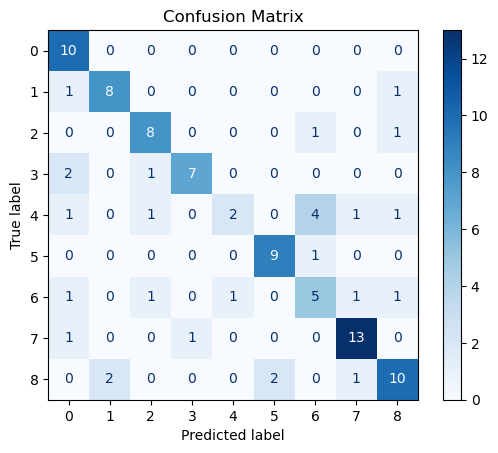

In [665]:
# Visualization Confusion Matrix
def visualization_confusion_matrix(model, test_x, true_y, label):
    plot = plot_confusion_matrix(model, test_x, true_y, display_labels=label, cmap=plt.cm.Blues)
    plot.ax_.set_title('Confusion Matrix')

# create labels :: ex) 0,1, ... ,7,8
labels = []
for i in range(0,len(all_tfidf)):
    labels.append(i)


visualization_confusion_matrix(svm_model, test_X, test_y, labels)


### Get Precision, Recall, F1 Score

---Result---
precision_score: 0.72
recall_score: 0.72
f1_score: 0.72


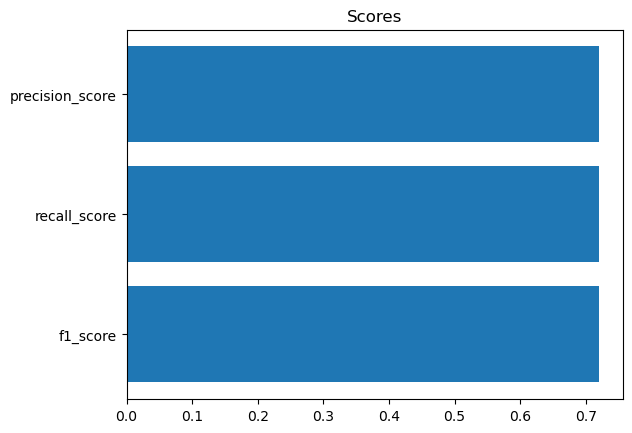

In [666]:
# Get precision, recall, f1 scores
def get_scores(true, pred):
    avr = 'micro'
    score = {'precision_score': precision_score(true, pred, average=avr),
             'recall_score': recall_score(true, pred, average=avr),
             'f1_score': f1_score(true, pred, average=avr)}

    return score

# Visualization Scores
def visualization_scores(score):
    x = []
    h = []
    for key, value in score.items():
        print(key + ": " + str(value))
        x.append(key)
        h.append(value)
    x.reverse()
    h.reverse()

    plt.barh(x, h)
    plt.title('Scores')
    plt.show()

# print Result (precision score, recall score, f1 score)
scores = get_scores(test_y, pred_y)
print('---Result---')
visualization_scores(scores)